In [1]:
# setting device on GPU if available, else CPU
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')
if torch.cuda.device_count() > 1:
    print("Using ", torch.cuda.device_count(), "GPUs!")

Using device: cuda

GeForce RTX 2080 Ti
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import copy
import os
import random
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from glob import glob
import functools
from PIL import Image
import argparse
import os
import numpy as np
import random
import time
import datetime
import json
from pathlib import Path


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import transformers

In [4]:
from PIL import Image
from torchvision import transforms
from core.ofa import OFATokenizer, OFAModel
from core.ofa.generate import sequence_generator

In [5]:
from transformers import (
    HfArgumentParser,
    TrainingArguments,
)

In [6]:
from ctl.vqa_arguments import VQAArguments

In [7]:
from core.datasets.vqa_gen_dataset import VqaGenDataset , VQACollator, VqaDataset
from core.ofa.label_smoothed_cross_entropy import AdjustLabelSmoothedCrossEntropyCriterion
from core.ofa import OFATokenizer
from core.ofa.modeling_ofa import OFAModelForVQA

In [8]:
pretrained ='/coc/scratch/sanisetty3/DLM//OFA-tiny'

tokenizer = OFATokenizer.from_pretrained(pretrained)
model = OFAModelForVQA.from_pretrained(pretrained, use_cache=False)

/coc/scratch/sanisetty3/DLM//OFA-tiny
<super: <class 'OFATokenizer'>, <OFATokenizer object>>


/srv/share2/sanisetty3/miniconda3/envs/ai-choreo/lib/python3.7/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525553989/work/aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [9]:
ann_file = os.path.join('/srv/scratch/sanisetty3/DLM/AliceMind/mPLUG/data/json/vqa_ocr_object/' ,"vqa_train_ocr.json")
vqa_root = '/srv/datasets/coco/'


In [63]:

def new_arange(x, *size):
    r"""
    Return a Tensor of `size` filled with a range function on the device of x.
    If size is empty, using the size of the variable x.
    """
    if len(size) == 0:
        size = x.size()
    return torch.arange(size[-1], device=x.device).expand(*size).contiguous()


In [148]:
ds = VqaDataset(
    ann_file=[ann_file],
    vqa_root=vqa_root,
)


/srv/share2/sanisetty3/miniconda3/envs/ai-choreo/lib/python3.7/site-packages/torchvision/transforms/transforms.py:330: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "


In [149]:
data_collator = VQACollator(tokenizer=tokenizer, max_seq_length=128)


In [150]:
len(ds)

443752

In [151]:
dl = DataLoader(ds, batch_size = 8, collate_fn=data_collator ,num_workers = 0, shuffle = True)


In [162]:
for batch in dl:
    break

In [163]:
batch.keys()

dict_keys(['input_ids', 'patch_images', 'patch_masks', 'decoder_input_ids', 'target', 'return_loss', 'attention_mask'])

In [164]:
print(tokenizer.batch_decode(batch["input_ids"], skip_special_tokens=True))

[' where is a heart?', ' what does the lady right front have in her hand?', " is this harry potter's owl?", ' what is the lady doing?', ' what color are the earbuds?', ' which room is this?', ' what is the person doing?', ' what tool do many people use other than this to till the ground?']


In [165]:
print(tokenizer.batch_decode(batch["target"], skip_special_tokens=True))

['on collar', 'fork', 'no', 'milking cow', 'white', 'kitchen', 'skiing', 'hoe']


In [166]:
target = batch["target"]

In [167]:
target

tensor([[  261, 19008,     2,     1],
        [34886,     2,     1,     1],
        [ 2362,     2,     1,     1],
        [22238,  7037, 12094,     2],
        [ 9830,     2,     1,     1],
        [23199,  8224,     2,     1],
        [13828,   154,     2,     1],
        [23712,     2,     1,     1]])

In [168]:
decoder_input_ids = batch["decoder_input_ids"]

In [169]:
decoder_input_ids

tensor([[    0,   261, 19008,     1],
        [    0, 34886,     1,     1],
        [    0,  2362,     1,     1],
        [    0, 22238,  7037, 12094],
        [    0,  9830,     1,     1],
        [    0, 23199,  8224,     1],
        [    0, 13828,   154,     1],
        [    0, 23712,     1,     1]])

In [170]:
at_mask = batch["attention_mask"]
at_mask

tensor([[1, 1, 1, 0],
        [1, 1, 0, 0],
        [1, 1, 0, 0],
        [1, 1, 1, 1],
        [1, 1, 0, 0],
        [1, 1, 1, 0],
        [1, 1, 1, 0],
        [1, 1, 0, 0]])

In [171]:
loss_fnc = AdjustLabelSmoothedCrossEntropyCriterion()

In [172]:
outp = model(**batch)

In [173]:
outp["logits"].shape

torch.Size([8, 4, 59457])

In [174]:
lprobs = model.get_normalized_probs(outp, log_probs=True) * 1
target = model.get_targets(batch)


In [175]:
lprobs.shape

torch.Size([8, 4, 59457])

In [176]:
target.shape

torch.Size([8, 4])

In [177]:
lprobs1 = lprobs[target != tokenizer.pad_token_id]


In [178]:
target2 = target[target != tokenizer.pad_token_id]

In [179]:
lprobs1.shape

torch.Size([21, 59457])

In [181]:
loss, sample_size, logging_output = loss_fnc(model,batch,0)

In [183]:
logging_output

{'loss': tensor(152.7043),
 'nll_loss': tensor(152.7043),
 'n_correct': 10,
 'total': 21}

In [26]:
mean, std = [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]
resolution = 480

In [27]:
patch_resize_transform = transforms.Compose([
    lambda image: image.convert("RGB"),
    transforms.Resize((resolution, resolution), interpolation=Image.BICUBIC),
    transforms.ToTensor(), 
    transforms.Normalize(mean=mean, std=std)
])

/srv/share2/sanisetty3/miniconda3/envs/DLM/lib/python3.9/site-packages/torchvision/transforms/transforms.py:332: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


In [28]:
txt = "How many blocks are there?"
inputs = tokenizer([txt], return_tensors="pt").input_ids
img = Image.open('./samples/i1.jpeg')
patch_img = patch_resize_transform(img).unsqueeze(0)

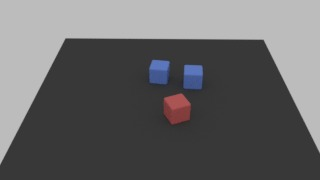

In [29]:
img

In [69]:
model = OFAModelForVQA.from_pretrained(ckpt_dir, use_cache=False)

In [70]:
check = torch.load("./OFA-tiny/pytorch_model.bin")

In [23]:
gen = model.generate(inputs, patch_images=patch_img, num_beams=5, no_repeat_ngram_size=3)

In [18]:
import transformers

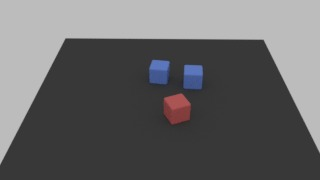

2


In [24]:
display(img)
print(tokenizer.batch_decode(gen, skip_special_tokens=True)[0].strip())

In [24]:
batch = {
            "input_ids": inputs,
            "patch_images":patch_img,
            'return_loss': True,
            "target" :inputs,

        }

In [21]:
def f(input_ids,patch_images,return_loss,defrw = 6):
    print(input_ids.shape)
    print(patch_images.shape)
    print(return_loss)

In [25]:
f(**batch)

TypeError: f() got an unexpected keyword argument 'target'